# MLP Test

In [89]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

path = '/content/agaricus-lepiota.data'
colnames=['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
df1 = pd.read_csv(path, sep=",", names=colnames)

significant_features = []

# 'class' 열을 제외한 범주형 변수에서 카이제곱 검정을 통해 유의미한 변수를 평가
for column in colnames[1:]:
    contingency_table = pd.crosstab(df1[column], df1['class'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.05:  # 유의수준 설정
        significant_features.append(column)

print("significant_features:", significant_features)

significant_features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


In [90]:
selected_columns = significant_features
train_df = df1[selected_columns]
train_df = pd.concat([df1['class'],train_df], axis=1)
train_df

#Label Encoding for ordinal features
label_encoder = LabelEncoder()
label_encoding_columns = ['population', 'ring-number','gill-spacing', 'gill-size']

#One-Hot Encoding for norminal features
one_hot_encoding_columns = [col for col in train_df.columns if col not in label_encoding_columns and col != 'class']

label_encoder = LabelEncoder()
for col in label_encoding_columns:
    train_df[col] = label_encoder.fit_transform(train_df[col])

encoded_df = pd.get_dummies(train_df[1:], columns=one_hot_encoding_columns)
print(encoded_df.head())


  class  gill-spacing  gill-size  ring-number  population  cap-shape_b  \
1     e             0          0            1           2            0   
2     e             0          0            1           2            1   
3     p             0          1            1           3            0   
4     e             1          0            1           0            0   
5     e             0          0            1           2            0   

   cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  ...  \
1            0            0            0            0  ...   
2            0            0            0            0  ...   
3            0            0            0            0  ...   
4            0            0            0            0  ...   
5            0            0            0            0  ...   

   spore-print-color_u  spore-print-color_w  spore-print-color_y  habitat_d  \
1                    0                    0                    0          0   
2                    0  

In [91]:
mapping = {'e': 1, 'p': 0}
encoded_df['class'] = encoded_df['class'].map(mapping)
encoded_df

,class,gill-spacing,gill-size,ring-number,population,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,...,spore-print-color_u,spore-print-color_w,spore-print-color_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
1,1,0,0,1,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,1,2,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1,0,0,1,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8120,1,0,0,1,4,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8121,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,0,1,1,4,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [92]:
X = encoded_df.drop(columns=['class'])
y = encoded_df['class']

In [93]:
encoded_df.shape

(8123, 108)

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Dataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y


class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = 107
hidden_sizes = [64, 32]
output_size = 2
model = MLPClassifier(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

batch_size = 64
shuffle = True
num_workers =1

kfold = KFold(n_splits=5)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []


for train_index, test_index in kfold.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_train = torch.tensor(y_train.values, dtype=torch.float32)
  y_test = torch.tensor(y_test.values, dtype=torch.float32)


  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(X_train)

      loss = criterion(outputs, y_train.type(torch.LongTensor))
      # loss = criterion(nn.Sigmoid(outputs),y_train)

      loss.backward()
      optimizer.step()

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      test_outputs = model(X_test)
      predicted = torch.argmax(test_outputs, dim=1)


  # accuracy = correct / total
  acc = accuracy_score(y_test, predicted)
  precision = precision_score(y_test, predicted)
  recall = recall_score(y_test, predicted)
  f1 = f1_score(y_test, predicted)

  accuracy_scores.append(acc)
  precision_scores.append(precision)
  recall_scores.append(recall)
  f1_scores.append(f1)

In [80]:
accuracy_scores

[0.9753846153846154, 1.0, 1.0, 1.0, 1.0]

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Dataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = 107
output_size = 2
criterion = nn.CrossEntropyLoss()
num_epochs = 100

batch_size = 64
shuffle = True
num_workers =1

kfold = KFold(n_splits=5)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kfold.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_train = torch.tensor(y_train.values, dtype=torch.float32)
  y_test = torch.tensor(y_test.values, dtype=torch.float32)


# 하이퍼파라미터 범위 정의
hidden_layer_sizes = [64, 128, 256]
learning_rates = [0.001, 0.01, 0.1]

best_params={'hidden_size':0,'learning_rate':0}
best_accuracy=0

for hidden_size in hidden_layer_sizes:
    for lr in learning_rates:

      optimizer = optim.Adam(model.parameters(), lr=lr)
      model = MLPClassifier(input_size, hidden_sizes, output_size)

      for epoch in range(num_epochs):
          optimizer.zero_grad()
          outputs = model(X_train)

          loss = criterion(outputs, y_train.type(torch.LongTensor))
          # loss = criterion(nn.Sigmoid(outputs),y_train)

          loss.backward()
          optimizer.step()

      model.eval()
      correct = 0
      total = 0

      with torch.no_grad():
          test_outputs = model(X_test)
          predicted = torch.argmax(test_outputs, dim=1)

      acc = accuracy_score(y_test, predicted)
      precision = precision_score(y_test, predicted)
      recall = recall_score(y_test, predicted)
      f1 = f1_score(y_test, predicted)

      accuracy_scores.append(acc)
      precision_scores.append(precision)
      recall_scores.append(recall)
      f1_scores.append(f1)

      print(f"best_params:{best_params}")
      if acc > best_accuracy:
          print(f'acc:{acc}')

          best_accuracy = acc
          best_params['hidden_size'] = hidden_size
          best_params['learning_rate'] = lr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best_params:{'hidden_size': 0, 'learning_rate': 0}
acc:0.687807881773399
best_params:{'hidden_size': 64, 'learning_rate': 0.001}
best_params:{'hidden_size': 64, 'learning_rate': 0.001}
best_params:{'hidden_size': 64, 'learning_rate': 0.001}
acc:0.6945812807881774
best_params:{'hidden_size': 128, 'learning_rate': 0.001}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best_params:{'hidden_size': 128, 'learning_rate': 0.001}
best_params:{'hidden_size': 128, 'learning_rate': 0.001}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best_params:{'hidden_size': 128, 'learning_rate': 0.001}
best_params:{'hidden_size': 128, 'learning_rate': 0.001}


In [95]:
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("mean acc:", mean_accuracy)
print("std acc:", std_accuracy)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
print("mean precision:", mean_precision)
print("std precision:", std_precision)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
print("mean recall:", mean_recall)
print("std recall:", std_recall)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print("mean F1 score:", mean_f1)
print("std F1 score:", std_f1)

print(best_params)

mean acc: 0.5171729611384784
std acc: 0.18466005015445158
mean precision: 0.24426096415247578
std precision: 0.18460302633397602
mean recall: 0.5860179706333553
std recall: 0.44306947080478826
mean F1 score: 0.3314505481892758
std F1 score: 0.23904425729454631
{'hidden_size': 128, 'learning_rate': 0.001}


# Other Models

In [ ]:
print(encoded_df.shape)

X = encoded_df.drop(columns=['class'])
y = encoded_df['class']

kfold = KFold(n_splits=5)

param_grid_SVC = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

param_grid_DT = {
    'criterion': ['gini', 'entropy'],  #분할 기준
    'max_depth': [None, 10, 20, 30, 40],  #최대 깊이
    'min_samples_split': [2, 5, 10],  #노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드 최소 샘플 수
}
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  #규제 파라미터
    'penalty': ['l1', 'l2'],  #규제 유형
    'solver': ['liblinear']  #작은 데이터셋에 적합한 솔버
}

models = [SVC(), DecisionTreeClassifier(), LogisticRegression()]
param_grids = [param_grid_SVC, param_grid_DT, param_grid_LR]


# models = [DecisionTreeClassifier(), LogisticRegression()]
# param_grids = [param_grid_DT, param_grid_LR]

for idx,model in enumerate(models):
    print(model)
    model_ = GridSearchCV(model, param_grids[idx], cv=None, n_jobs=-1)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        # acc = model.score(X_test, y_test)
        # print("score:", score)

    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    print("mean acc:", mean_accuracy)
    print("std acc:", std_accuracy)

    mean_precision = np.mean(precision_scores)
    std_precision = np.std(precision_scores)
    print("mean precision:", mean_precision)
    print("std precision:", std_precision)

    mean_recall = np.mean(recall_scores)
    std_recall = np.std(recall_scores)
    print("mean recall:", mean_recall)
    print("std recall:", std_recall)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print("mean F1 score:", mean_f1)
    print("std F1 score:", std_f1)

    print("------------------------")
    print("Optimal Param:", model_.best_params_)
    print("========================")

  # Taking too much time for SVC

(8123, 108)
SVC()
mean acc: 0.9850985221674877
std acc: 0.028587349055160763
mean precision: 0.9388924575372343
std precision: 0.1183400305847927
mean recall: 1.0
std recall: 0.0
mean F1 score: 0.9642365669077678
std F1 score: 0.0695788737394007
------------------------
Optimal Param: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
DecisionTreeClassifier()
mean acc: 0.9908866995073892
std acc: 0.012421951732930299
mean precision: 0.9866920152091255
std precision: 0.026615969581749034
mean recall: 0.9770216962524655
std recall: 0.032558720167995873
mean F1 score: 0.9814301948735216
std F1 score: 0.022819479701918787
------------------------
Optimal Param: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
LogisticRegression()
mean acc: 0.895870708601743
std acc: 0.18381004603022688
mean precision: 0.9546074895977809
std precision: 0.08323574396374059
mean recall: 0.8932960893854748
std recall: 0.21340782122905028
mean F1 score: 0.9020303649841923
std F1 

In [101]:
accuracy_scores

[0.5298461538461539, 1.0, 1.0, 0.9544334975369458, 1.0]

## Getting rid of selected Column (personal selection)

In [102]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
path = '/content/agaricus-lepiota.data'


#Get rid of gill-attachment / stalk-root / veil-type / veil-colour / ring-number
colnames=['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
df1 = pd.read_csv(path, sep=",", names=colnames)

df1 = df1.drop(columns=['gill-attachment'])
df1 = df1.drop(columns=['stalk-root'])
df1 = df1.drop(columns=['veil-type'])
df1 = df1.drop(columns=['veil-color'])
df1 = df1.drop(columns=['ring-number'])


new_colnames = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-spacing','gill-size','gill-color','stalk-shape','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','ring-type','spore-print-color','population','habitat']

significant_features = []
for column in new_colnames[1:]:
    contingency_table = pd.crosstab(df1[column], df1['class'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.05:
        significant_features.append(column)

print("significant_features:", significant_features)

significant_features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-type', 'spore-print-color', 'population', 'habitat']


In [103]:
# print(len(new_column))
# print(len(colnames))

In [104]:
selected_columns = significant_features
train_df = df1[selected_columns]
train_df = pd.concat([df1['class'],train_df], axis=1)
train_df

#Label Encoding을 for ordinal features
label_encoder = LabelEncoder()
label_encoding_columns = ['population','gill-spacing', 'gill-size']

#One-Hot Encoding for norminal features
one_hot_encoding_columns = [col for col in train_df.columns if col not in label_encoding_columns and col != 'class']

label_encoder = LabelEncoder()
for col in label_encoding_columns:
    train_df[col] = label_encoder.fit_transform(train_df[col])

encoded_df = pd.get_dummies(train_df[1:], columns=one_hot_encoding_columns)

In [105]:
mapping = {'e': 1, 'p': 0}
encoded_df['class'] = encoded_df['class'].map(mapping)
encoded_df

,class,gill-spacing,gill-size,population,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,...,spore-print-color_u,spore-print-color_w,spore-print-color_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
1,1,0,0,2,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,3,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,1,0,0,2,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8120,1,0,0,4,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8121,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,0,1,4,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [106]:
print(encoded_df.shape)
from sklearn.metrics import mean_absolute_error, r2_score

X = encoded_df.drop(columns=['class'])
y = encoded_df['class']

kfold = KFold(n_splits=5)

param_grid_SVC = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

param_grid_DT = {
    'criterion': ['gini', 'entropy'],  #분할 기준
    'max_depth': [None, 10, 20, 30, 40],  #최대 깊이
    'min_samples_split': [2, 5, 10],  #노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드 최소 샘플 수
}
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  #규제 파라미터
    'penalty': ['l1', 'l2'],  #규제 유형
    'solver': ['liblinear']  #작은 데이터셋에 적합한 솔버
}


models = [SVC(), DecisionTreeClassifier(), LogisticRegression()]
param_grids = [param_grid_SVC, param_grid_DT, param_grid_LR]

for idx,model in enumerate(models):
    print(model)
    model_ = GridSearchCV(model, param_grids[idx], cv=None, n_jobs=-1)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        # acc = model.score(X_test, y_test)
        # print("score:", score)

    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    print("mean acc:", mean_accuracy)
    print("std acc:", std_accuracy)

    mean_precision = np.mean(precision_scores)
    std_precision = np.std(precision_scores)
    print("mean precision:", mean_precision)
    print("std precision:", std_precision)

    mean_recall = np.mean(recall_scores)
    std_recall = np.std(recall_scores)
    print("mean recall:", mean_recall)
    print("std recall:", std_recall)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print("mean F1 score:", mean_f1)
    print("std F1 score:", std_f1)

    print("------------------------")
    print("Optimal Param:", model_.best_params_)
    print("========================")
  # Taking too much time for SVC

(8123, 96)
SVC()
mean acc: 0.9863300492610836
std acc: 0.02733990147783252
mean precision: 0.9426356589147286
std precision: 0.11472868217054262
mean recall: 1.0
std recall: 0.0
mean F1 score: 0.9665158371040725
std F1 score: 0.06696832579185519
------------------------
Optimal Param: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
DecisionTreeClassifier()
mean acc: 0.9980295566502463
std acc: 0.0039408866995073845
mean precision: 1.0
std precision: 0.0
mean recall: 0.9936883629191321
std recall: 0.012623274161735719
mean F1 score: 0.9967935871743487
std F1 score: 0.006412825651302611
------------------------
Optimal Param: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
LogisticRegression()
mean acc: 0.8968559302766199
std acc: 0.18435153897077317
mean precision: 0.9577142857142856
std precision: 0.08457142857142856
mean recall: 0.8932960893854748
std recall: 0.21340782122905028
mean F1 score: 0.9035959227141337
std F1 score: 0.1413240581565185
--

In [107]:
accuracy_scores #LR

[0.5298461538461539, 1.0, 1.0, 0.9544334975369458, 1.0]

# Regression test with Best Param

mean acc: 1.0
std acc: 0.0
mean precision: 1.0
std precision: 0.0
mean recall: 1.0
std recall: 0.0
mean F1 score: 1.0
std F1 score: 0.0


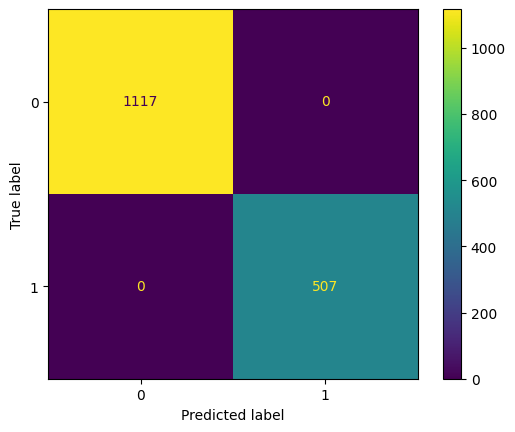

In [108]:
model_ = LogisticRegression(C= 100, penalty= 'l2', solver= 'liblinear')
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

y_test_lst = []
y_pred_lst = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    y_pred_lst.append(y_pred)
    y_test_lst.append(y_test.values)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    # acc = model.score(X_test, y_test)
    # print("score:", score)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("mean acc:", mean_accuracy)
print("std acc:", std_accuracy)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
print("mean precision:", mean_precision)
print("std precision:", std_precision)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
print("mean recall:", mean_recall)
print("std recall:", std_recall)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print("mean F1 score:", mean_f1)
print("std F1 score:", std_f1)
print("========================")

cm_res = []
for i in range(len(y_test_lst)):
  cm = confusion_matrix(y_test_lst[i], y_pred_lst[i], labels=model_.classes_)
  cm_res = +cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res,display_labels=model_.classes_)
disp.plot()
plt.show()


In [109]:
accuracy_scores #LR

[1.0, 1.0, 1.0, 1.0, 1.0]

# DT test with Best Param

mean acc: 0.9980295566502463
std acc: 0.0039408866995073845
mean precision: 1.0
std precision: 0.0
mean recall: 0.9936883629191321
std recall: 0.012623274161735719
mean F1 score: 0.9967935871743487
std F1 score: 0.006412825651302611


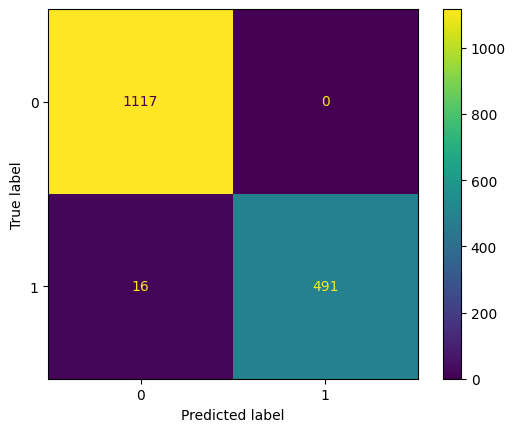

In [110]:
from sklearn.metrics import mean_absolute_error, r2_score

model_ = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 10)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

y_test_lst = []
y_pred_lst = []


for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    y_pred_lst.append(y_pred)
    y_test_lst.append(y_test.values)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    # acc = model.score(X_test, y_test)
    # print("score:", score)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("mean acc:", mean_accuracy)
print("std acc:", std_accuracy)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
print("mean precision:", mean_precision)
print("std precision:", std_precision)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
print("mean recall:", mean_recall)
print("std recall:", std_recall)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print("mean F1 score:", mean_f1)
print("std F1 score:", std_f1)
print("========================")


cm_res = []
for i in range(len(y_test_lst)):
  cm = confusion_matrix(y_test_lst[i], y_pred_lst[i], labels=model_.classes_)
  cm_res = +cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res,display_labels=model_.classes_)
disp.plot()
plt.show()

In [111]:
accuracy_scores

[1.0, 1.0, 1.0, 1.0, 0.9901477832512315]

# SVM test with Best Param

mean acc: 0.9991379310344828
std acc: 0.0017241379310344751
mean precision: 0.9950530035335688
std precision: 0.009893992932862172
mean recall: 1.0
std recall: 0.0
mean F1 score: 0.9974955277280859
std F1 score: 0.005008944543828254


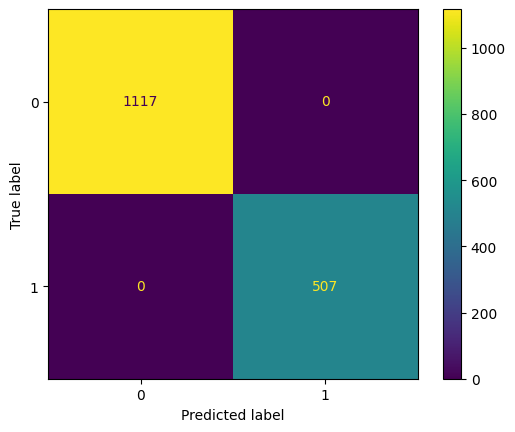

In [112]:
model_ = SVC(C= 1, gamma= 0.001, kernel= 'linear')
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

y_test_lst = []
y_pred_lst = []


for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)

    y_pred_lst.append(y_pred)
    y_test_lst.append(y_test.values)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    # acc = model.score(X_test, y_test)
    # print("score:", score)


mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("mean acc:", mean_accuracy)
print("std acc:", std_accuracy)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
print("mean precision:", mean_precision)
print("std precision:", std_precision)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
print("mean recall:", mean_recall)
print("std recall:", std_recall)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print("mean F1 score:", mean_f1)
print("std F1 score:", std_f1)
print("========================")

cm_res = []
for i in range(len(y_test_lst)):
  cm = confusion_matrix(y_test_lst[i], y_pred_lst[i], labels=model_.classes_)
  cm_res = +cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res,display_labels=model_.classes_)
disp.plot()
plt.show()

In [113]:
accuracy_scores

[1.0, 1.0, 1.0, 0.9956896551724138, 1.0]